```
#---------------------------
# Author: Sajjad Ahmed
# Version: 5
# Updated: 28-11-2018
#---------------------------
```

# Importing libraries

In [2]:
from nilearn import plotting
import nilearn.datasets as dt
from nilearn.plotting import plot_stat_map, show

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import warnings
warnings.filterwarnings(action="ignore")

from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import GridSearchCV

## importing preprocessing functions

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.datasets import make_moons, make_circles, make_classification

## importing Classifires 

In [3]:
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.metrics import accuracy_score

### Fetching the dataset

In [3]:
haxby_dataset = dt.fetch_haxby()
fmri_filename = haxby_dataset.func[0]

In [4]:
haxby_dataset

{'anat': ['C:\\Users\\Gigabyte/nilearn_data\\haxby2001\\subj2\\anat.nii.gz'],
 'description': b'Haxby 2001 results\n\n\nNotes\n-----\nResults from a classical fMRI study that investigated the differences between\nthe neural correlates of face versus object processing in the ventral visual\nstream. Face and object stimuli showed widely distributed and overlapping\nresponse patterns.\n\nContent\n-------\nThe "simple" dataset includes\n    :\'func\': Nifti images with bold data\n    :\'session_target\': Text file containing session data\n    :\'mask\': Nifti images with employed mask\n    :\'session\': Text file with condition labels\n\n\nThe full dataset additionally includes\n    :\'anat\': Nifti images with anatomical image\n    :\'func\': Nifti images with bold data\n    :\'mask_vt\': Nifti images with mask for ventral visual/temporal cortex\n    :\'mask_face\': Nifti images with face-reponsive brain regions\n    :\'mask_house\': Nifti images with house-reponsive brain regions\n    :\

In [5]:
fmri_filename

'C:\\Users\\Gigabyte/nilearn_data\\haxby2001\\subj2\\bold.nii.gz'

## Dataset details
1.	```anat.nii.gz:``` this file includes high-resolution anatomical images except subject 6.
2.	```bold.nii.gz:``` It contains 4D fMRI timeseries image. The time series contains all the 12 runs of the original experiment.
3.	```musk.nii.gz:``` various musk’s in functional space provided by the original authors. Here “vt” refers “ventral temporal”, “faces” and “house” masks are GLM contrast-based localizer maps.
4.	```Labels.txt: ```A two-column text file that contains the simulation condition and the experimental for each volume in the timeseries images. The labels have string name like “face”, “house” etc [1].


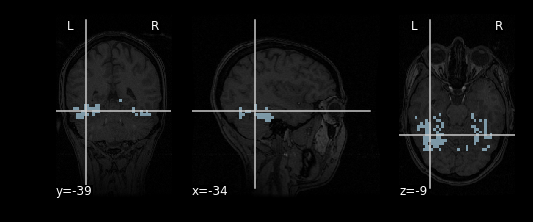

In [5]:
# Convert the fMRI volume's to a data matrix
# ..........................................
# We will use the :class:`nilearn.input_data.NiftiMasker` to extract the
# fMRI data on a mask and convert it to data series.
#
# The mask is a mask of the Ventral Temporal streaming coming from the
# Haxby study:
mask_filename = haxby_dataset.mask_vt[0]

# Let's visualize it, using the subject's anatomical image as a
# background

plotting.plot_roi(mask_filename, bg_img=haxby_dataset.anat[0],
                  cmap='Paired')


In [6]:
###########################################################################
# Now we use the NiftiMasker.
#
# We first create a masker, giving it the options that we care
# about. Here we use standardizing of the data, as it is often important
# for decoding
from nilearn.input_data import NiftiMasker

masker = NiftiMasker(mask_img=mask_filename, standardize=True)

# We give the masker a filename and retrieve a 2D array ready
# for machine learning with scikit-learn
fmri_masked = masker.fit_transform(fmri_filename)

In [7]:
###########################################################################
# The variable "fmri_masked" is a numpy array:
print(fmri_masked)

[[ 7.6757914e-01  2.3108709e+00 -2.0519446e-01 ... -1.0261141e+00
   8.7993503e-02  2.0720530e+00]
 [ 5.5640829e-01  1.6833442e+00 -2.4644940e-01 ... -7.0238096e-01
  -3.4570050e-01  2.0341012e+00]
 [ 7.6757914e-01  1.9186667e+00  1.0802227e-03 ... -9.9374086e-01
  -2.7630946e-01  2.1479564e+00]
 ...
 [-4.2905572e-01 -1.6896113e+00 -7.4150860e-01 ... -1.5440873e+00
   1.8054218e+00 -1.6709729e-01]
 [-1.4749458e-01 -1.8072726e+00 -2.4644940e-01 ... -1.7707006e+00
   1.5452055e+00  7.8169519e-01]
 [-2.1788488e-01 -1.4542887e+00  1.0802227e-03 ... -1.6412073e+00
   1.2676412e+00  8.9555031e-01]]


In [8]:
###########################################################################
# Its shape corresponds to the number of time-points times the number of
# voxels in the mask
print(fmri_masked.shape)

(1452, 464)


## Load the behavioral labels

In [9]:
###########################################################################

# The behavioral labels are stored in a CSV file, separated by spaces.
#
# We use pandas to load them in an array.

# Load behavioral information
behavioral = pd.read_csv(haxby_dataset.session_target[0], sep=" ")
# print(behavioral)

In [10]:
###########################################################################
# Retrieve the experimental conditions, that we are going to use as
# prediction targets in the decoding
conditions = behavioral['labels']


In [11]:
conditions.value_counts()

rest            588
face            108
shoe            108
house           108
bottle          108
scissors        108
chair           108
scrambledpix    108
cat             108
Name: labels, dtype: int64

In [12]:
###########################################################################
# Restrict the analysis to cats and faces
# ........................................
#
# As we can see from the targets above, the experiment contains many
# conditions, not all that interest us for decoding.
#
# To keep only data corresponding to faces or cats, we create a
# mask of the samples belonging to the condition.
condition_mask = conditions.isin(['face', 'cat', 'scissors'])

# We apply this mask in the sampe direction to restrict the
# classification to the face vs cat discrimination
fmri_masked = fmri_masked[condition_mask]

In [13]:
###########################################################################
# We now have less samples
print(fmri_masked.shape)

(324, 464)


In [14]:
###########################################################################
# We apply the same mask to the targets
conditions = conditions[condition_mask]
print(conditions.shape)

(324,)


# Creating Dataframe

In [15]:
fmri_masked = pd.DataFrame(fmri_masked)
conditions = pd.DataFrame(conditions)

In [16]:
print(fmri_masked.shape)
print(conditions.shape)

(324, 464)
(324, 1)


# Preprocessing Data

In [17]:
encoder = LabelEncoder()

In [18]:
conditions = pd.DataFrame(encoder.fit_transform(conditions))

In [19]:
conditions.head()

,0
0,2
1,2
2,2
3,2
4,2


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000020E1D1147B8>]],
      dtype=object)

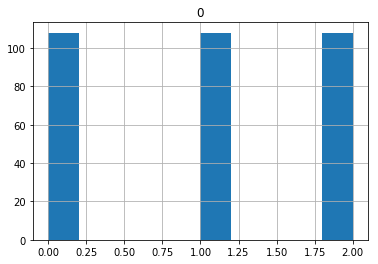

In [20]:
conditions.hist()

In [21]:
fmri_masked.head()

,0,1,2,3,4,5,6,7,8,9,...,454,455,456,457,458,459,460,461,462,463
0,0.661994,2.703075,0.042335,1.653256,-1.129792,1.774859,-0.076726,1.138999,0.032221,-0.605421,...,-2.543707,-2.108905,-0.552270,2.029958,3.622423,1.595472,0.717969,-1.058487,-0.692656,2.337715
1,1.647458,2.977618,0.743669,2.214843,-1.205380,2.396514,0.926928,1.023805,-0.346617,0.197116,...,-1.773946,-1.732411,-0.158145,2.167300,3.718992,1.471873,0.333331,-0.734754,-0.796742,2.869039
2,1.858629,2.036328,0.743669,2.042047,-0.877833,2.587793,1.094204,2.002947,-1.041153,0.780780,...,-1.707010,-1.302133,-0.034981,2.258862,3.171768,1.018675,0.298364,-0.670008,-0.831438,2.603377
3,1.753043,2.389312,0.578649,2.128445,-0.928225,2.205236,0.926928,0.851016,-0.914874,0.561906,...,-1.773946,-1.786196,0.014284,1.984177,3.043010,1.265874,0.455716,-0.702381,-0.866133,3.020846
4,1.788238,2.546193,0.578649,2.344440,-1.129792,2.253056,1.038445,0.966209,-0.978013,-0.386547,...,-1.489469,-1.893766,0.088183,2.396204,3.397096,1.430673,0.350814,-0.540514,-0.935524,2.944942


In [22]:
scaler_obj = MinMaxScaler(feature_range=(0,1))

In [23]:
fmri_masked= scaler_obj.fit_transform(fmri_masked)

In [24]:
fmri_masked = pd.DataFrame(fmri_masked)
conditions = pd.DataFrame(conditions)

In [25]:
fmri_masked.head()

,0,1,2,3,4,5,6,7,8,9,...,454,455,456,457,458,459,460,461,462,463
0,0.708955,0.946154,0.598291,0.715686,0.335404,0.834951,0.428571,0.726190,0.451220,0.433735,...,0.000000,0.021739,0.250000,0.898990,0.982249,0.770492,0.726563,0.310811,0.254967,0.703488
1,0.917910,1.000000,0.743590,0.843137,0.316770,0.961165,0.626374,0.702381,0.378049,0.566265,...,0.190871,0.097826,0.331633,0.929293,1.000000,0.745902,0.640625,0.378378,0.235099,0.784884
2,0.962687,0.815385,0.743590,0.803922,0.397516,1.000000,0.659341,0.904762,0.243902,0.662651,...,0.207469,0.184783,0.357143,0.949495,0.899408,0.655738,0.632813,0.391892,0.228477,0.744186
3,0.940298,0.884615,0.709402,0.823529,0.385093,0.922330,0.626374,0.666667,0.268293,0.626506,...,0.190871,0.086957,0.367347,0.888889,0.875740,0.704918,0.667969,0.385135,0.221854,0.808140
4,0.947761,0.915385,0.709402,0.872549,0.335404,0.932039,0.648352,0.690476,0.256098,0.469880,...,0.261411,0.065217,0.382653,0.979798,0.940828,0.737705,0.644531,0.418919,0.208609,0.796512


In [26]:
X_train, X_test, y_train, y_test = train_test_split(fmri_masked, conditions, test_size=0.20, random_state=42)

In [27]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(259, 464)
(259, 1)
(65, 464)
(65, 1)


### Learning Curver drawer funciton

In [28]:

def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
#     print(train_scores.shape)
#     print("Training Score: %.2f %%"%(accuracy_score(train_scores,y_train)*100))
#     print("Test score: ",test_scores*100)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="b")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="b",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    plt.show()


# Training the model

Training on different classifiers to get rough idea

In [29]:
h = .02  # step size in the mesh

names = ["Nearest Neighbors", "Linear SVM", "SVM", "Gaussian Process",
         "Decision Tree", "Random Forest", "Multilayer perceptron", "AdaBoost",
         "Naive Bayes", "QDA"]

classifiers = [
    KNeighborsClassifier(3),
    SVC(kernel="linear", C=0.025),
    SVC(C=1000, kernel='poly'),
    GaussianProcessClassifier(1.0 * RBF(1.0)),
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    MLPClassifier(alpha=1),
    AdaBoostClassifier(),
    GaussianNB(),
    QuadraticDiscriminantAnalysis()
]

# iterate over classifiers
for name, clf in zip(names, classifiers):
    # ax = plt.subplot(len(datasets), len(classifiers) + 1, i)
    clf.fit(X_train,y_train)
    prediction = clf.predict(X_test)
    score = accuracy_score(y_test,prediction)
    print("---------",name,"----------")
#     print("Prediction: ", prediction)
    print("Score: %.2f %%"%(score*100))
    print("\n\n")


--------- Nearest Neighbors ----------
Score: 90.77 %



--------- Linear SVM ----------
Score: 75.38 %



--------- SVM ----------
Score: 95.38 %



--------- Gaussian Process ----------
Score: 24.62 %



--------- Decision Tree ----------
Score: 58.46 %



--------- Random Forest ----------
Score: 56.92 %



--------- Multilayer perceptron ----------
Score: 95.38 %



--------- AdaBoost ----------
Score: 56.92 %



--------- Naive Bayes ----------
Score: 50.77 %



--------- QDA ----------
Score: 30.77 %





## 1. Naive Bayes

In [30]:
clf = GaussianNB()
clf.fit(X_train, y_train)
pred = clf.predict(X_test)
print("Score: %.2f %%"%(accuracy_score(pred,y_test)*100))

Score: 50.77 %


## 2. Random Forest

In [31]:
clf = RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1)
clf.fit(X_train, y_train)
pred = clf.predict(X_test)
print("Score: %.2f %%"%(accuracy_score(pred,y_test)*100))

Score: 50.77 %


## 3. SVM

In [32]:
clf = SVC(kernel="rbf", C=100)
clf.fit(X_train, y_train)
pred = clf.predict(X_test)
print("Score: %.2f %%"%(accuracy_score(pred,y_test)*100))

Score: 96.92 %


In [33]:
cv = ShuffleSplit(test_size=0.2, random_state=42)

### 3.1 Since SVM is doing well, now we apply grid search to find the best parameters that minimizes the loss

In [34]:
from sklearn.model_selection import GridSearchCV

In [35]:
parameters = {'kernel':('linear',  'rbf', 'sigmoid'), 'C':[1,10,20,50,70,100,500,1000,5000]}
svr = SVC()
clf = GridSearchCV(svr, parameters)
clf.fit(X_train, y_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'kernel': ('linear', 'rbf', 'sigmoid'), 'C': [1, 10, 20, 50, 70, 100, 500, 1000, 5000]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [36]:
print("best estimator: ", clf.best_estimator_, "\n")
print("best parameters: ", clf.best_params_, "\n")
print("Score: %.2f %%\n"%(clf.best_score_*100))

best estimator:  SVC(C=70, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False) 

best parameters:  {'C': 70, 'kernel': 'rbf'} 

Score: 93.44 %



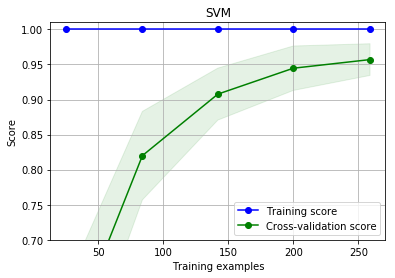

In [37]:
plot_learning_curve(SVC(C=70,kernel='rbf'), "SVM", 
                    fmri_masked, conditions, ylim=(0.7, 1.01), cv=cv, n_jobs=4)

# 4 Multilayer perceptron (MLP)

In [38]:
clf = MLPClassifier(hidden_layer_sizes=(464,),activation="tanh" )
clf.fit(X_train, y_train)
pred = clf.predict(X_test)
print("Score: %.2f %%"%(accuracy_score(pred,y_test)*100))

Score: 95.38 %


### 4.1 Now we try the second best classifire which is Multilayer perceptron (MLP) and find the best parameters

In [39]:
parameters = {'hidden_layer_sizes':((464,)), 'activation':['identity', 'logistic', 'tanh', 'relu'],'solver':['sgd', 'adam'],'alpha':[.0001,.001,.01,.1,1]}
svr = MLPClassifier()
clf = GridSearchCV(svr, parameters)
clf.fit(X_train, y_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'hidden_layer_sizes': (464,), 'activation': ['identity', 'logistic', 'tanh', 'relu'], 'solver': ['sgd', 'adam'], 'alpha': [0.0001, 0.001, 0.01, 0.1, 1]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [40]:
print("best estimator: ", clf.best_estimator_, "\n")
print("best parameters: ", clf.best_params_, "\n")
print("Score: %.2f %%\n"%(clf.best_score_*100))

best estimator:  MLPClassifier(activation='logistic', alpha=0.01, batch_size='auto',
       beta_1=0.9, beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=464, learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False) 

best parameters:  {'activation': 'logistic', 'alpha': 0.01, 'hidden_layer_sizes': 464, 'solver': 'adam'} 

Score: 92.66 %



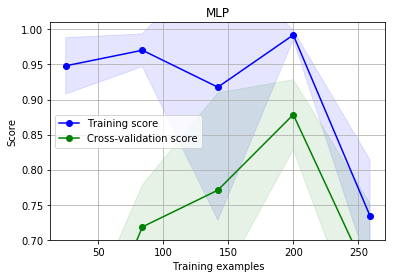

In [41]:
plot_learning_curve(MLPClassifier(activation='logistic', alpha= .01, hidden_layer_sizes= 464, solver= 'adam'), "MLP", 
                    fmri_masked, conditions, ylim=(0.7, 1.01), cv=cv, n_jobs=4)

# 5 K-Nearest Neighbors

In [42]:
clf = KNeighborsClassifier(3)
clf.fit(X_train, y_train)
pred = clf.predict(X_test)
print("Score: %.2f %%"%(accuracy_score(pred,y_test)*100))

Score: 90.77 %


### 5.1 Now we try to find the best parameters of k-Nearest Neighbors

In [43]:
parameters = {'n_neighbors':(1,5,10), 'weights':['uniform', 'distance'], 'algorithm' : ['auto', 'ball_tree', 'kd_tree', 'brute']}
svr = KNeighborsClassifier()
clf = GridSearchCV(svr, parameters)
clf.fit(X_train, y_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform'),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_neighbors': (1, 5, 10), 'weights': ['uniform', 'distance'], 'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [44]:
print("best estimator: ", clf.best_estimator_, "\n")
print("best parameters: ", clf.best_params_, "\n")
print("Score: %.2f %%\n"%(clf.best_score_*100))

best estimator:  KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=1, p=2,
           weights='uniform') 

best parameters:  {'algorithm': 'auto', 'n_neighbors': 1, 'weights': 'uniform'} 

Score: 95.37 %



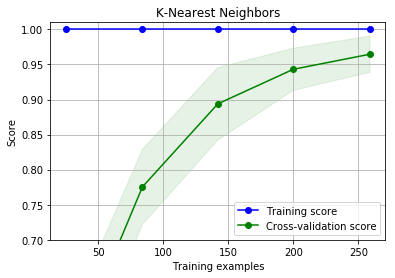

In [45]:
plot_learning_curve(KNeighborsClassifier(algorithm='auto', n_neighbors= 1, weights='uniform'), "K-Nearest Neighbors", fmri_masked, conditions, ylim=(0.7, 1.01), cv=cv, n_jobs=4)
